# Vision Transformer

> Machine learning engineering is 10% machine learning and 90% engineering.
>
> *[Chip Huyen](https://twitter.com/chipro/status/1315678863347920896?lang=en), my intellectual hero*

To be honest, I have no evidence whether she is telling the truth or not, even with Elon Musk agreed with her. But I trusted her, as well as other (seemingly) trustworthy people who guided.

Daniel Bourke put the responsibilities of MLE as "deploying the SOTA models from research straight to the users (with many more steps)". The many more steps often involve: data collection/preprocess/process, and if you are involved with MLOps as well, monitoring, logging, and updating models.

But let's start small at first. This project focuses on learning the necessary tools of the trade, getting familiar with the end-to-end training process (from data to deployment). I will ignore the data problem, and also the complicated deployment problem (just a Hugging Face Space).

This notebook is about replicationg of research paper, specifically, Vision Transformer (ViT). 

# Set up

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import timm
from torchinfo import summary
from helper import plot, engine, setup_data, utils
from torch import nn
from torchvision import transforms
import torchmetrics
torch.backends.cuda.matmul.allow_tf32 = True

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# No complicated transformations needed for now
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])        
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [4]:
# Added supports for multiple workers
setup_data.get_metadata??

Signature: setup_data.get_metadata(dataset)
Source:   
def get_metadata(dataset):
    """
    Returns the metadata for the dataset.

    Args:
        dataset (torchvision.datasets.ImageFolder): Dataset for which metadata is required
    
    Returns:
        classes (list): List of class names
        class_to_idx (dict): Dictionary mapping class names to indices
        idx_to_class (dict): Dictionary mapping indices to class names
    """
    classes, class_to_idx = dataset.classes, dataset.class_to_idx
    idx_to_class = {value: key for key, value in class_to_idx.items()}
    return classes, class_to_idx, idx_to_class
File:      ~/Nutri-2.0/helper/setup_data.py
Type:      function

In [5]:
BATCH_SIZE = 84

train_loader, valid_loader, test_loader, test_data = setup_data.get_data_loaders(manual_transforms, manual_transforms, BATCH_SIZE, 2)
classes, class_to_idx, idx_to_class = setup_data.get_metadata(test_data)

In [6]:
plot.imshow??

Signature: plot.imshow(image, ax=None, title=None)
Source:   
def imshow(image, ax=None, title=None):
    """
    imshow for IMAGENET-style transformed images in
    torch.Tensor format.

    Args:
        image (torch.Tensor): Image to be plotted
        ax (matplotlib.axes.Axes): Axes object to plot the image on
        title (str): Title for the image
    
    Returns:
        ax (matplotlib.axes.Axes): Axes object with the image plotted
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.permute((1, 2, 0))
    
    # Undo preprocessing
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = (std * image + mean)
    
    
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    
    return ax
File:      ~/Nutri-2.0/helper/plot.py
Type:      function

In [7]:
image_batch, label_batch = next(iter(train_loader))

<Axes: title={'center': 'deviled_eggs'}>

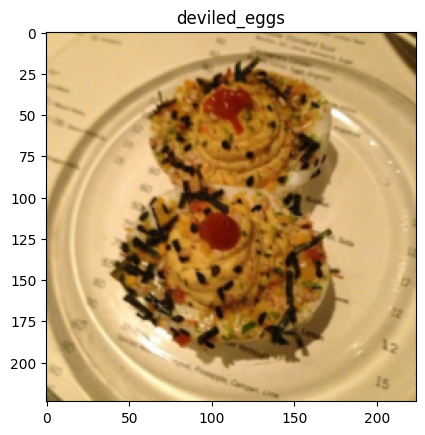

In [8]:
plot.imshow(image_batch[-1], title=classes[label_batch[-1]])

In [9]:
plot.image_grid??

Signature:
plot.image_grid(
    images,
    labels,
    idx_to_class,
    rows=2,
    cols=4,
    figsize=(20, 10),
)
Source:   
def image_grid(images, labels, idx_to_class, rows=2, cols=4, figsize=(20, 10)):
    """
    Plots a grid of images and their labels.

    Args:
        images (torch.Tensor): Images to be plotted
        labels (torch.Tensor): Labels for the images
        idx_to_class (dict): Dictionary mapping indices to class names
        rows (int): Number of rows in the grid
        cols (int): Number of columns in the grid
        figsize (tuple): Size of the figure
    
    Returns:
        None
    """
    _, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax = imshow(images[i], ax=ax, title=idx_to_class[labels[i].item()])
    plt.tight_layout()
    plt.show()
File:      ~/Nutri-2.0/helper/plot.py
Type:      function

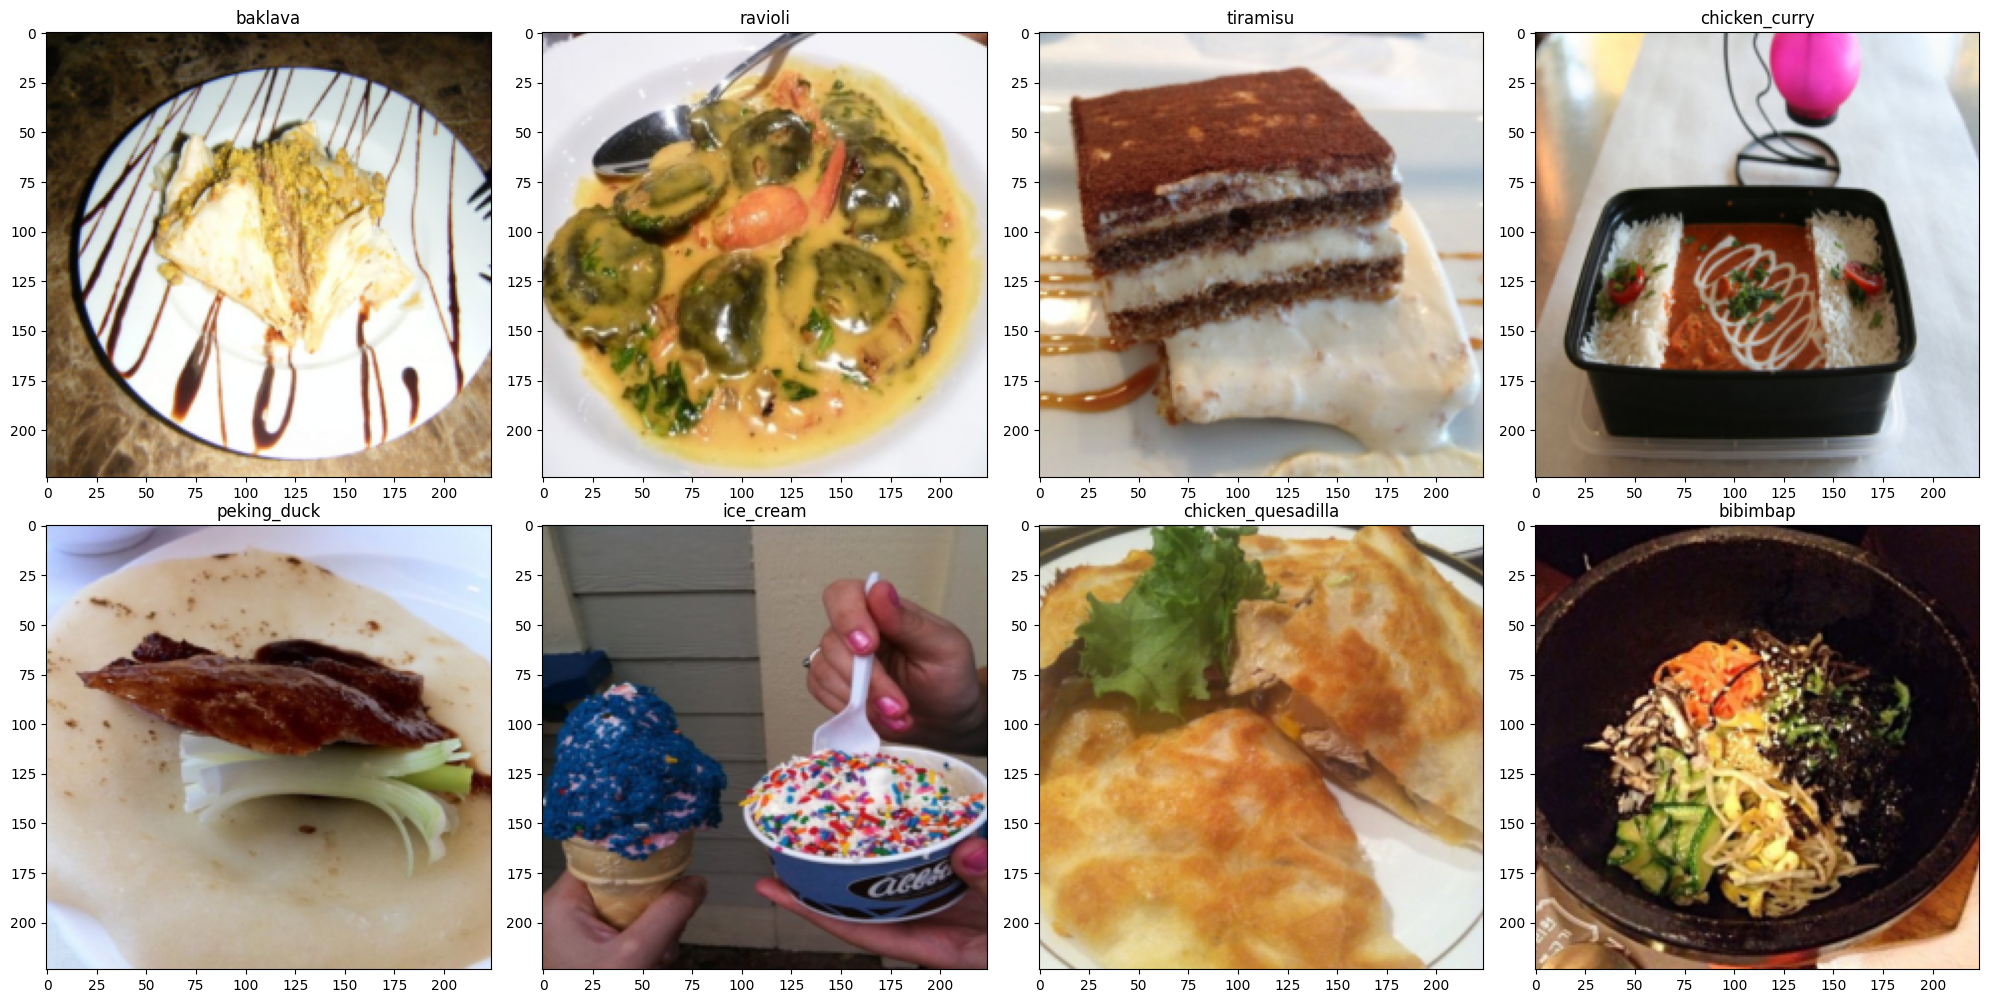

In [10]:
plot.image_grid(image_batch, label_batch, idx_to_class)

# Replication

## Patch (with Positional) Embedding (and classifier tokens)

### Shape and visualization

In [11]:
height = 224
width = 224
color_channels = 3
patch_size = 16

# Hence
number_of_patches = height * width // (patch_size**2)
print(f"Number of patches for height {height} and width {width} with patch size {patch_size} is {number_of_patches}")

Number of patches for height 224 and width 224 with patch size 16 is 196


Input &rarr; Model &rarr; Output

In term of shape:
- Input: $H \times W \times C$
- Output: $N \times (P^{2} \times C)$

In [12]:
# Input
embedding_layer_input_shape = (height, width, color_channels)

# Output
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


Following Bourke, I now have the input shape and output shape. At this point I actually questioned the point of this exercise. It seemed trivial. And no, this is not when some cold hard mind-blowing truth hit, telling me the utter importance of explicitly doing algebra with codes. Well, I just need to stop distrusting him and follow.

Willing to do anything for the job? I have to keep my words.

Next exercise is creating visualization of the patchified image.

### Patchified image

In [13]:
image = image_batch[0]
image

tensor([[[-1.7583, -1.7412, -1.7412,  ..., -1.8953, -1.8610, -1.8782],
         [-1.6898, -1.6898, -1.7069,  ..., -1.8610, -1.8782, -1.8610],
         [-1.6555, -1.7069, -1.7412,  ..., -1.7412, -1.7754, -1.8097],
         ...,
         [-0.4911, -0.6281, -0.5424,  ...,  1.1187,  0.7591,  0.7077],
         [-0.4397, -0.5596, -0.5082,  ...,  1.2385,  0.9303,  0.8104],
         [-0.4397, -0.3541, -0.4568,  ...,  1.1529,  1.1529,  1.0502]],

        [[-1.7381, -1.7031, -1.7031,  ..., -1.8256, -1.7906, -1.7906],
         [-1.6681, -1.6506, -1.6506,  ..., -1.7906, -1.8081, -1.8081],
         [-1.6331, -1.6681, -1.6856,  ..., -1.7206, -1.7556, -1.8081],
         ...,
         [-0.6877, -0.8452, -0.7752,  ...,  0.8354,  0.3978,  0.2752],
         [-0.6001, -0.7402, -0.7227,  ...,  1.1155,  0.7129,  0.5203],
         [-0.6001, -0.5301, -0.6527,  ...,  1.1155,  1.0630,  0.8704]],

        [[-1.6999, -1.6476, -1.6476,  ..., -1.6650, -1.6476, -1.6476],
         [-1.6302, -1.6127, -1.6127,  ..., -1

<Axes: >

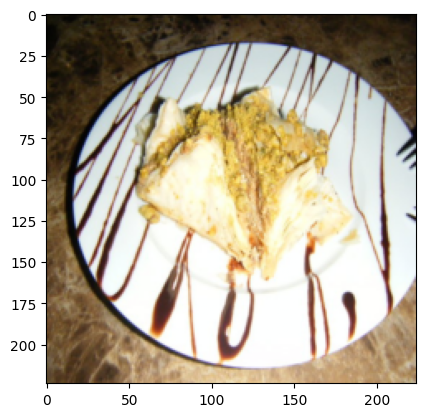

In [14]:
plot.imshow(image)

In [15]:
image.shape

torch.Size([3, 224, 224])

<Axes: >

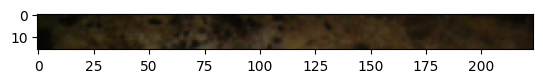

In [16]:
# First row
plot.imshow(image[:,:patch_size,:])

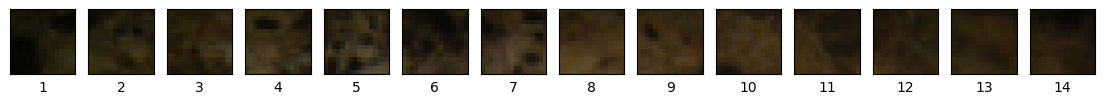

In [17]:
_, axs = plt.subplots(nrows=1,
                      ncols=width // patch_size,
                      figsize=(width // patch_size, width // patch_size),
                      sharex=True,
                      sharey=True)

for i, patch in enumerate(range(0, width, patch_size)):
    plot.imshow(image[:, :patch_size, patch:(patch + patch_size)], ax=axs[i])
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Clunky, with heavy algebra on the side, but I make it work.

Now for the whole image

In [18]:
label = label_batch[0]

Number of patches per row: 14        
Number of patches per column: 14        
Total patches: 196        
Patch size: 16 pixels x 16 pixels


Text(0.5, 0.98, 'baklava -> Patchified')

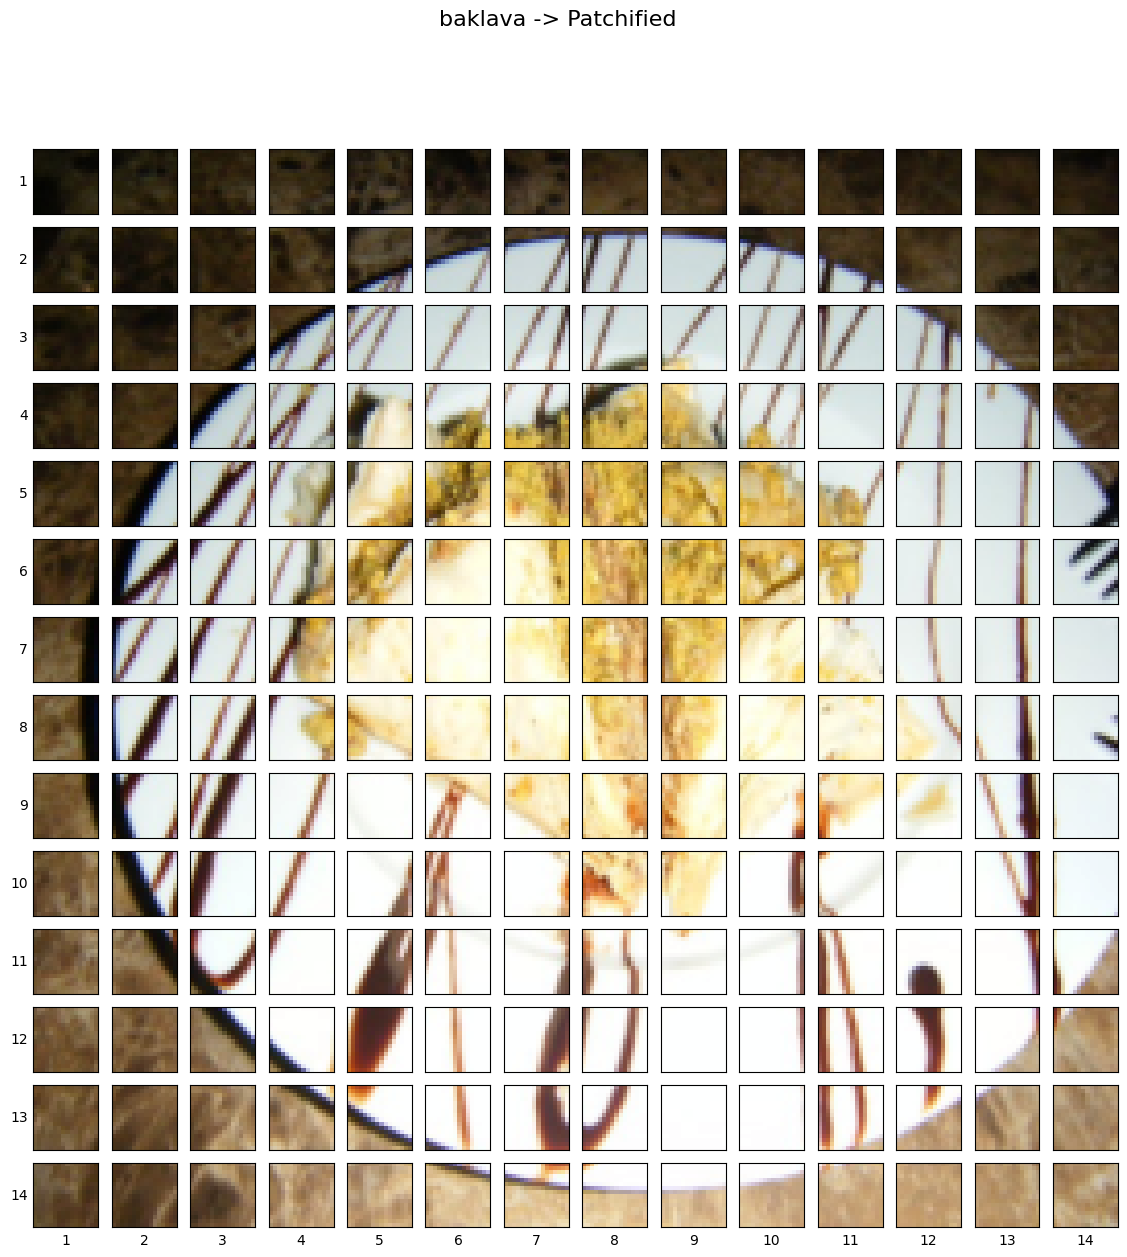

In [19]:
num_patches = height // patch_size

print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=num_patches,
                      ncols=num_patches,
                      figsize=(num_patches, num_patches),
                      sharex=True,
                      sharey=True)
for i, patch_height in enumerate(range(0, height, patch_size)):
    for j, patch_width in enumerate(range(0, width, patch_size)):
        plot.imshow(image[:, patch_height:(patch_height + patch_size), patch_width:(patch_width + patch_size)], ax=axs[i, j])
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{idx_to_class[int(label)]} -> Patchified", fontsize=16)

It hit me that the exercise served 2 purposes:

1. It was fun.
2. It built intuition.

Well, I hope it is. Because it turned out that the patches can be simply obtained from `torch.nn.Conv2d()` and `torch.nn.Flatten()` i.e. a 2D convolution layer followed by a flattening layer.

The simple trick is just setting `kernel_size = stride = number_of_patches`

**An embedding vector** is a compressed representation of the real data point. Each embedding dimension can be thought of as an aspect of the data. For example, we can (hopefully and estimatingly) capture a person's health through various aspects such as his BMI, his age, his blood pressure, etc. Well, the meaning of each dimension, when talking about such high-dimensional space, will not be that clear. But I can definitely realize that the more aspects, the better (hope) to accurately capture the data.

In this case, the number of dimensions of the embedding vector is the one aspect of each color channel of each patch, which led to $16*16*3=768$

In [20]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray'

In [21]:
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768,
                   kernel_size=(patch_size, patch_size),
                   stride=patch_size,
                   padding=0)

In [22]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [658, 340, 343, 542, 563]


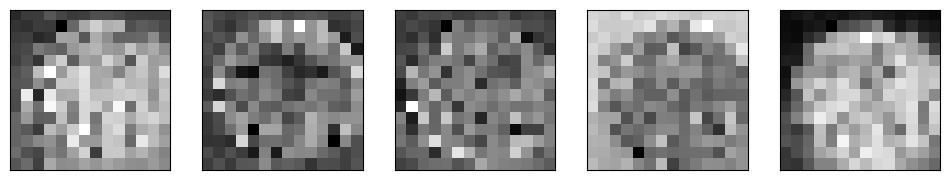

In [23]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [24]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [25]:
nn.Flatten?

Init signature: nn.Flatten(start_dim: int = 1, end_dim: int = -1) -> None
Docstring:     
Flattens a contiguous range of dims into a tensor. For use with :class:`~nn.Sequential`.

Shape:
    - Input: :math:`(*, S_{\text{start}},..., S_{i}, ..., S_{\text{end}}, *)`,'
      where :math:`S_{i}` is the size at dimension :math:`i` and :math:`*` means any
      number of dimensions including none.
    - Output: :math:`(*, \prod_{i=\text{start}}^{\text{end}} S_{i}, *)`.

Args:
    start_dim: first dim to flatten (default = 1).
    end_dim: last dim to flatten (default = -1).

Examples::
    >>> input = torch.randn(32, 1, 5, 5)
    >>> # With default parameters
    >>> m = nn.Flatten()
    >>> output = m(input)
    >>> output.size()
    torch.Size([32, 25])
    >>> # With non-default parameters
    >>> m = nn.Flatten(0, 2)
    >>> output = m(input)
    >>> output.size()
    torch.Size([160, 5])
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File: 

It seems that I need to define the range of dimensions I want to flatten out. By default, an instance of the layer will flatten every dimension starts 1 (leaving dimension 0 intact). For this case, I can just set `start_dim=2` and I am done.

In [26]:
flatten = nn.Flatten(start_dim=2)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


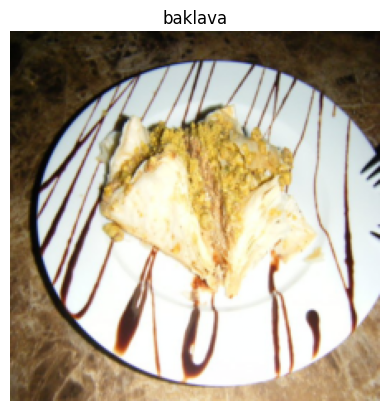

In [27]:
# Workflow
# 1. View single image
plot.imshow(image)
plt.title(idx_to_class[int(label)])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

- Current shape: (1, 768, 196)
- Desired shape: (196, 768)

This is where `torch.Tensor.permute` comes to the rescue.

In [28]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


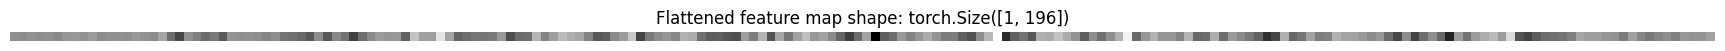

In [29]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 2))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [30]:
torch.set_printoptions(precision=3, linewidth=125, sci_mode=False)
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.143,  0.104,  0.212,  0.138,  0.167,  0.065,  0.239,  0.291,  0.186,  0.337,  0.079,  0.157,  0.178,  0.151,
           0.313,  0.177,  0.098,  0.518, -0.393, -1.008,  0.159, -0.095, -0.399, -0.202, -0.726,  0.233,  0.164,  0.190,
           0.137,  0.006,  0.110, -0.267, -0.321, -0.457, -0.705,  0.120, -0.710,  0.034, -0.306, -1.092, -0.368,  0.047,
           0.357,  0.266,  0.274, -0.614,  0.988,  0.422,  0.423,  1.529,  0.486, -0.545, -0.391, -0.260, -0.240, -0.170,
           0.309, -0.897, -0.415, -0.365,  0.758, -0.008,  0.391,  0.852,  0.666,  0.498, -0.026, -0.736, -0.641,  0.082,
           0.337,  1.065, -1.052, -0.189,  0.105,  0.255,  0.028,  0.698,  0.622, -0.347, -0.657, -0.601, -0.777, -0.871,
           0.389, -0.134,  0.731, -0.780,  0.521, -0.235,  0.445,  0.920,  0.275,  0.451,  0.079, -0.518, -1.157, -0.436,
           0.486, -2.156, -0.630, -0.400,  0.310, -0.045,  0.254,  0.608,  0.213, -0.162, -0.148, -0.608, -0.823,  0.110,
           0.798,  1.955

In [31]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    def __init__(self, in_channels: int, patch_size: int, embedding_dim: int) -> None:
        super().__init__()

        self.patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=embedding_dim,
                      kernel_size=patch_size,
                      stride=patch_size,
                      padding=0),
            nn.Flatten(start_dim=2)
        )
    
    def forward(self, x: torch.Tensor):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x = self.patch_embedding(x)
        return x.permute(0, 2, 1)

In [32]:
patchifier = PatchEmbedding(3, 16, 768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchifier(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [33]:
summary(patchifier, 
        input_size=(1, 3, 224, 224), # try swapping this for (1, 3, 225, 225)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Sequential (patch_embedding)           [1, 3, 224, 224]     [1, 768, 196]        --                   True
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (1)                       [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### Classifier token

> Similar to BERT's `[ class ]` token, we prepend a learnable embedding to the sequence of embedded patches ($z^{0}_{0}=x_{\text{class}}$), whose state at the output of the Transformer encoder $z^{0}_{\text(L)}$ serves as the image representation $y$ (Eq. 4).

"Prepend... to the embedded patches" means creating a learnable embedding in the shape of embedding dimension $M$ and add it to the beginning of the batch of embedding patches (with `torch.cat()`). In terms of shape, the `number_of_patches` will increase by 1.

In [34]:
# Example output: patch_embedded_image
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


Oh, in case the readers cannot tell - I did write codes verbatim from Daniel Bourke sometimes. Particularly the comment, I cannot add or remove a single word from it.

In [35]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.000,  1.000,  1.000,  ...,  1.000,  1.000,  1.000],
         [-0.057, -1.108, -0.220,  ...,  0.631,  0.636,  0.108],
         [ 0.101, -1.089, -0.333,  ...,  0.633,  0.564,  0.034],
         ...,
         [-0.351,  0.257, -0.191,  ..., -0.166, -0.309, -0.302],
         [-0.563,  0.372, -0.059,  ..., -0.308, -0.302, -0.234],
         [-0.137,  0.038, -0.410,  ..., -0.231, -0.243, -0.071]]], grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Positional embedding

Real positional embedding uses something such as the cosine function, but let's use random number at first.

Daniel Bourke does it in a more general way, but the equation used $\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}$, the size of the positional embedding tensor is set equal to the size of the prepended embedding.

From this, all I have to do is creating a vector in the same as the current `patch_embedded_image_with_class_embedding` and add to it.

In [36]:
position_embedding = nn.Parameter(torch.rand_like(patch_embedded_image_with_class_embedding),
                                  requires_grad=True)

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[0.446, 0.016, 0.446, 0.246, 0.692, 0.854, 0.632, 0.071, 0.795, 0.255],
         [0.100, 0.752, 0.162, 0.534, 0.261, 0.753, 0.214, 0.402, 0.232, 0.049],
         [0.129, 0.287, 0.061, 0.365, 0.099, 0.901, 0.895, 0.908, 0.640, 0.626],
         [0.452, 0.304, 0.782, 0.372, 0.585, 0.835, 0.210, 0.492, 0.458, 0.988],
         [0.063, 0.713, 0.703, 0.751, 0.006, 0.329, 0.278, 0.883, 0.907, 0.266],
         [0.054, 0.358, 0.741, 0.444, 0.292, 0.087, 0.984, 0.726, 0.049, 0.489],
         [0.999, 0.379, 0.051, 0.792, 0.081, 0.564, 0.488, 0.583, 0.182, 0.140],
         [0.310, 0.085, 0.544, 0.586, 0.313, 0.132, 0.005, 0.873, 0.173, 0.951],
         [0.517, 0.319, 0.948, 0.749, 0.403, 0.940, 0.697, 0.993, 0.357, 0.942],
         [0.321, 0.462, 0.743, 0.694, 0.082, 0.733, 0.242, 0.818, 0.590, 0.471]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [37]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.446,  1.016,  1.446,  ...,  1.254,  1.427,  1.750],
         [ 0.043, -0.357, -0.058,  ...,  0.641,  0.920,  0.283],
         [ 0.230, -0.802, -0.272,  ...,  1.231,  1.310,  0.597],
         ...,
         [ 0.410,  0.594,  0.740,  ...,  0.366, -0.070,  0.166],
         [-0.220,  0.588,  0.671,  ...,  0.020, -0.106,  0.471],
         [ 0.317,  0.943, -0.074,  ...,  0.438,  0.551,  0.111]]], grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [38]:
# The whole thing in one cell (remember to print the tensor shape along the way)
# 1. Set patch size
patch_size = 16

# 2. Get the image dimension
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch size dimension added: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(3, patch_size, 768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print("Patch embedding shape:", patch_embedding.shape)

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print("Class token embedding shape:", class_token.shape)

# 7. Prepend class token to patch embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
print("Patch embedding with class token shape:", patch_embedding_with_class_token.shape)

# 8. Positional embedding
number_of_patches = (height * width) // pow(patch_size, 2)
position_embedding = nn.Parameter(torch.rand_like(patch_embedding_with_class_token),
                                  requires_grad=True)

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_with_class_token + position_embedding
print("Patch and position embedding shape:", patch_and_position_embedding.shape)

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch size dimension added: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Multi-Head Self-attention Layer (MSA)

The Transformer Encoder has the architecture:
$$
\textbf{The MSA block: }
\text{Input (embedded patches)}
\rightarrow \text{LayerNorm}
\rightarrow \text{Multi-Head Self-attention}
\rightarrow \text{Intermediate Output (residual)}
$$
$$
\textbf{The MLP block: }
\text{Intermediate Input (residual)}
\rightarrow \text{LayerNorm}
\rightarrow \text{Multi-Layer Perceptron}
\rightarrow \text{Output (residual)}
$$
corresponding to the equation
$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1},
\hspace{1cm} \ell=1 \ldots L
\end{aligned}
$$

Pardon my digression, but the innovations (from just multilayer perception) lied in 3 aspects:
1. Residual Connection, introduced in *[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)*
2. Layer Normalization, introduced in *[Layer Normalization](https://arxiv.org/abs/1607.06450)*
3. Multi-Head Self-attention, a generalization of MLP, introduced in *[Attention Is All You Need](https://arxiv.org/abs/1706.03762)*

### MSA Block

In [39]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block
    (LayerNorm + MultiHeadAttention)
    """
    def __init__(self,
                 embedding_dimension: int = 768,
                 num_heads: int = 12,
                 attn_dropout: float = 0) -> None:
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dimension,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [40]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dimension=768, # from Table 1 
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [41]:
patch_and_position_embedding

tensor([[[ 1.007,  1.983,  1.523,  ...,  1.822,  1.620,  1.282],
         [ 1.755,  1.169,  0.741,  ..., -0.020,  1.188,  0.555],
         [ 1.967,  0.975,  0.964,  ..., -0.502,  1.378,  0.653],
         ...,
         [ 0.487,  0.719, -0.250,  ...,  0.470,  0.222,  0.406],
         [ 0.453,  0.445, -0.458,  ...,  1.362,  0.871,  0.559],
         [-0.378,  0.846, -0.061,  ...,  1.431,  1.017,  0.314]]], grad_fn=<AddBackward0>)

In [42]:
patched_image_through_msa_block

tensor([[[ 0.087, -0.186,  0.307,  ..., -0.073, -0.251, -0.166],
         [ 0.073, -0.181,  0.327,  ...,  0.110, -0.138, -0.035],
         [ 0.079, -0.143,  0.238,  ...,  0.162, -0.159, -0.035],
         ...,
         [ 0.040, -0.210,  0.284,  ..., -0.104, -0.193, -0.212],
         [ 0.099, -0.139,  0.223,  ..., -0.053, -0.159, -0.205],
         [ 0.100, -0.150,  0.104,  ..., -0.014, -0.103, -0.131]]], grad_fn=<TransposeBackward0>)

Same shape, different value

There is no skip connection yet. In PyTorch, the skip connection is usually added when creating the whole model.

### MLP Block

In [43]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dimension: int = 768,
                 mlp_size: int = 3072,
                 dropout: float = 0.1) -> None:
        super().__init__()
        self.layer_norm = nn.LayerNorm(embedding_dimension)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dimension, # Same as the output of MSA block
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dimension),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [44]:
mlp_block = MLPBlock(embedding_dimension=768, # from Table 1 
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [45]:
patched_image_through_mlp_block

tensor([[[-0.546, -0.533,  0.121,  ..., -0.739, -0.188, -0.015],
         [-0.240, -0.557,  0.170,  ..., -0.656,  0.193, -0.114],
         [-0.237, -0.480,  0.280,  ..., -0.345,  0.222, -0.197],
         ...,
         [-0.526, -0.000,  0.032,  ..., -0.000,  0.051,  0.162],
         [-0.589, -0.000,  0.109,  ..., -0.472, -0.181,  0.014],
         [-0.567, -0.628,  0.185,  ..., -0.438, -0.099, -0.003]]], grad_fn=<MulBackward0>)

### Transformer Encoder

In [46]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1,
                 attn_dropout: float = 0) -> None:
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim,
                                                     num_heads,
                                                     attn_dropout)
        
        self.mlp_block = MLPBlock(embedding_dim,
                                  mlp_size,
                                  mlp_dropout)
        
    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x

        return x

<a href="https://imgflip.com/i/7qtwz3"><img src="https://i.imgflip.com/7qtwz3.jpg" title="made at imgflip.com"/></a>
> Yes, skip connection is as simple as that

In [47]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [48]:
nn.TransformerEncoderLayer?

Init signature:
nn.TransformerEncoderLayer(
    d_model: int,
    nhead: int,
    dim_feedforward: int = 2048,
    dropout: float = 0.1,
    activation: Union[str, Callable[[torch.Tensor], torch.Tensor]] = <function relu at 0x7f8e35f8d1b0>,
    layer_norm_eps: float = 1e-05,
    batch_first: bool = False,
    norm_first: bool = False,
    device=None,
    dtype=None,
) -> None
Docstring:     
TransformerEncoderLayer is made up of self-attn and feedforward network.
This standard encoder layer is based on the paper "Attention Is All You Need".
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
in a different way during application.

Args:
    d_model: the number of expected features in the input (required).
    nhead: the number of heads in the multiheadattention models (required).
 

In [49]:
# PyTorch built-in
pytorch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                               nhead=12,
                                                               dim_feedforward=3072,
                                                               dropout=0.1,
                                                               activation='gelu',
                                                               batch_first=True,
                                                               norm_first=True)
pytorch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [50]:
summary(model=pytorch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

The built-in method has been reported with faster operation and apparent saving in memory. Better, it can also be use with `torch.nn.TransformerEncoder()` to quickly stack the layers together (there are 12 layers for Vit-Base per the paper).

## ViT

Putting it all together

In [51]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters as the default"""
    def __init__(self,
                 img_size: int = 224,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 num_transformer_layers: int = 12,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072,
                 num_heads: int = 12,
                 attn_dropout: float = 0,
                 mlp_dropout: float = 0.1,
                 embedding_dropout: float = 0.1,
                 num_classes: int = 1000) -> None:
        super().__init__()
        
        if img_size % patch_size != 0:
            raise ValueError(f"Image size must be divisible by patch size, but image size is {img_size} and patch size is {patch_size}.")
        
        self.num_patches = (img_size**2) // patch_size**2
        
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim),
                                            requires_grad=True)
        self.embedding_dropout = nn.Dropout(p = embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                    nhead=num_heads,
                                                                    dim_feedforward=mlp_size,
                                                                    dropout=mlp_dropout,
                                                                    activation='gelu',
                                                                    batch_first=True,
                                                                    norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_transformer_layers)

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])

        return x

In [52]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [53]:
vit = ViT(num_classes=len(classes))
vit(torch.randn(1, 3, 224, 224))

tensor([[ 0.103, -0.615,  0.477,  0.905, -0.145,  0.105,  0.245, -0.181, -0.539, -0.340, -0.222,  0.615,  0.117, -0.082,
         -0.396, -0.430,  0.176, -0.006, -0.029,  0.150, -0.020,  1.098,  0.444,  0.873, -0.380,  0.468,  0.240, -0.141,
          0.327, -0.406,  1.137, -0.170, -0.228,  0.504, -0.779, -0.078, -1.040, -0.037,  0.829, -0.215,  0.581, -0.266,
          0.091,  0.728, -0.040,  0.588,  0.430,  1.039, -0.088, -0.442, -0.289,  0.855,  0.027, -0.158,  0.032,  0.092,
          0.524,  0.435,  0.337, -0.636, -0.052, -0.573,  0.043,  1.280, -2.123,  0.021,  0.315, -0.533, -0.156, -0.288,
          0.281, -0.369, -0.623, -0.012,  0.690, -0.832, -0.368, -0.176, -0.356, -0.065,  0.094,  0.112, -0.229,  0.689,
         -1.001, -0.058, -0.229,  0.857, -0.450,  0.296,  0.846,  0.368, -0.730,  0.698,  0.336, -0.707, -1.224, -0.134,
         -0.805,  0.443, -0.030]], grad_fn=<AddmmBackward0>)

In [54]:
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [32, 3, 224, 224]    [32, 101]            7,239,936            True
├─PatchEmbedding (patch_embedding)                 [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Sequential (patch_embedding)                [32, 3, 224, 224]    [32, 768, 196]       --                   True
│    │    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    │    └─Flatten (1)                            [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                      [32, 197, 768]       [32, 197, 768]       --                   --
├─TransformerEncoder (transformer_encoder)         [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                     

In [55]:
torch_vit = timm.create_model('vit_base_patch16_224', num_classes = len(classes))
summary(model=torch_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)    [32, 3, 224, 224]    [32, 101]            152,064              True
├─PatchEmbed (patch_embed)               [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (proj)                     [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Identity (norm)                   [32, 196, 768]       [32, 196, 768]       --                   --
├─Dropout (pos_drop)                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity (patch_drop)                  [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity (norm_pre)                    [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (blocks)                    [32, 197, 768]       [32, 197, 768]       --                   True
│    └─Block (0)      

The number of parameters are different due to the way each model is constructed. Overall, they are the same.

# Training

In [56]:
EPOCHS = 2
loss_fn = torch.nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=len(classes)).to(device)

In [57]:
vit = ViT(num_classes=101).to(device)
compiled_vit = torch.compile(vit)

In [58]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3,
                             fused=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [59]:
results = engine.train(vit,
                train_loader,
                valid_loader,
                loss_fn,
                optimizer,
                scheduler,
                accuracy_fn,
                device,
                EPOCHS,
                threshold=[1e-5])

  0%|          | 0/2 [00:00<?, ?it/s]

Training model::   0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 4.65515 | Train accuracy: 0.01


Making predictions::   0%|          | 0/396 [00:00<?, ?it/s]

Test loss: 4.63750 | Test accuracy: 0.01
Epoch 1 of 2
-------------------------------
Train loss: 4.65515 | Train accuracy: 0.0100
Valid loss: 4.63750 | Valid accuracy: 0.0101


Training model::   0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 4.63480 | Train accuracy: 0.01


Making predictions::   0%|          | 0/396 [00:00<?, ?it/s]

Test loss: 4.62516 | Test accuracy: 0.01
Epoch 2 of 2
-------------------------------
Train loss: 4.63480 | Train accuracy: 0.0094
Valid loss: 4.62516 | Valid accuracy: 0.0098


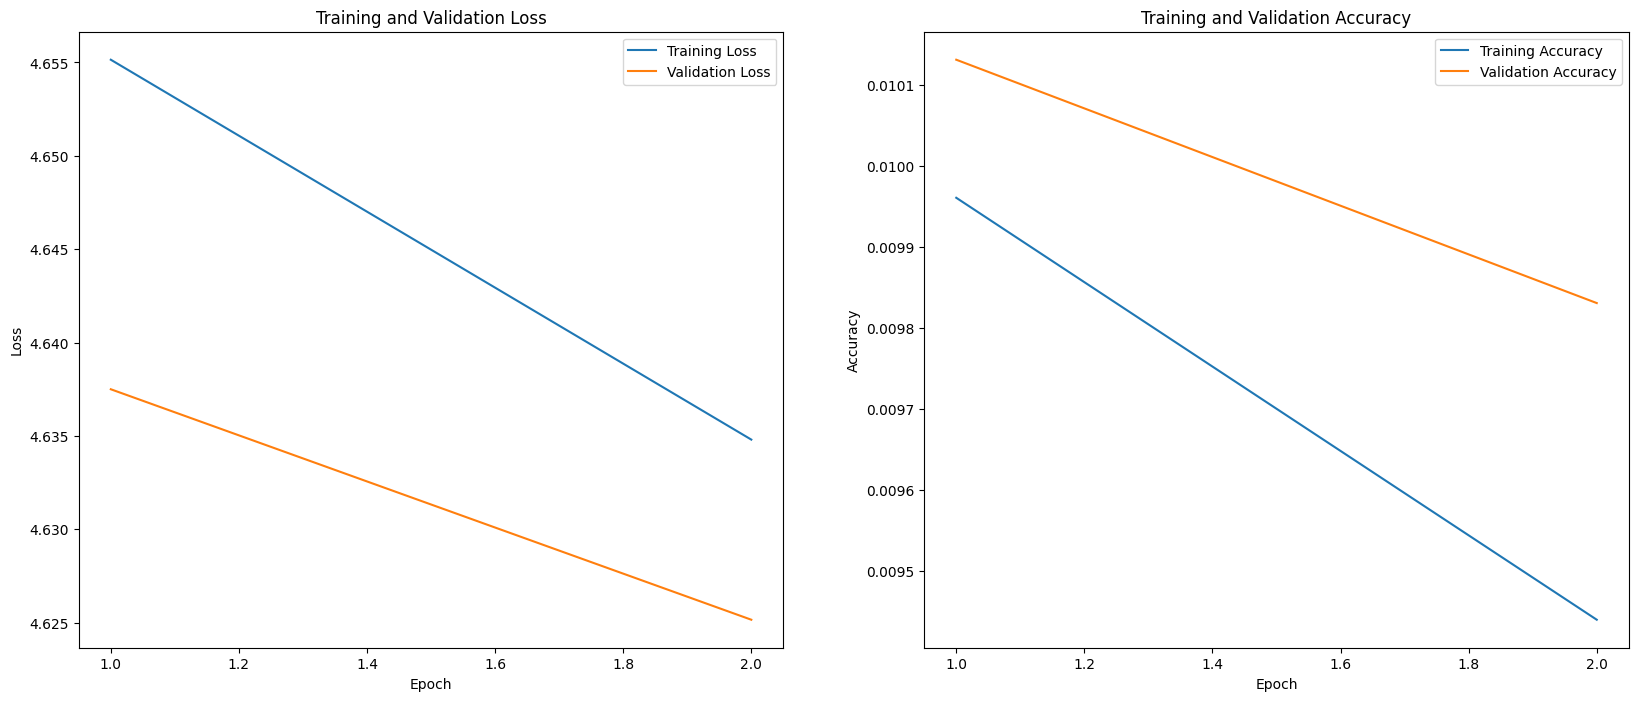

In [60]:
plot.plot_training(results['train_losses'], results["valid_losses"],
                   results['train_accuracies'], results["valid_accuracies"])